In [54]:
# Standard imports
import pandas as pd
import sys 
import os
import seaborn as sns
import os
import shutil
import numpy as np
import xtrack as xt
import matplotlib
import matplotlib.pyplot as plt
import copy
# Local imports
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='svg'

In [55]:
def get_amplitude_detuning(line, nemitt_x=1.e-6, nemitt_y=1.e-6, num_turns=100, zeropad=100000):
    '''
    returns axx, axy, ayx, ayy that correspond to the first order amplitude-detuning,
    estimated through tracking.
    The relations between tune (Q) and action (J) in this case is:
    $$ Q_x = Q_{x,0} + axx * Jx + axy * Jy $$
    $$ Q_y = Q_{y,0} + ayx * Jx + ayy * Jy $$
    '''

    egeom_x = nemitt_x / line.particle_ref.gamma0
    egeom_y = nemitt_y / line.particle_ref.gamma0

    frequency = np.fft.fftfreq(zeropad)

    sigma = 2
    num_r = 50
    JJ = np.linspace(0.01, sigma**2/2., num_r)
    A_norm = np.sqrt(2*JJ).flatten()
    other_norm = 0.01
     

    particles = line.build_particles(x_norm=A_norm, y_norm=other_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)
    
    particles0 = copy.deepcopy(particles)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y =  line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axx = np.polyfit(JJ*egeom_x, qx, 1)[0]
    ayx = np.polyfit(JJ*egeom_x, qy, 1)[0]

    # switch x and y
    particles = line.build_particles(x_norm=other_norm, y_norm=A_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y = line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axy = np.polyfit(JJ*egeom_y, qx, 1)[0]
    ayy = np.polyfit(JJ*egeom_y, qy, 1)[0]

    return axx, axy, ayx, ayy, JJ, qx, qy, particles0

In [56]:
l_optics= [
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_0/xtrack_0000/collider.json",
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_1/xtrack_0000/collider.json",
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_2/xtrack_0000/collider.json",
    ]
l_beta = [(0.7, 0.7), (0.7, 2.8), (0.9, 1.8)]
I = 450
for optics, (betax, betay) in zip(
    l_optics,
    l_beta,
):
    collider = xt.Multiline.from_json(optics)
    collider.build_trackers()
    collider.vars['beambeam_scale'] = 0
    tw = collider.lhcb1.twiss()
    qx0 = tw.qx
    qy0 = tw.qy

    axx, axy, ayx, ayy, JJ, qx, qy, particles0 = get_amplitude_detuning(collider.lhcb1)
    break
    # print(f"axx = {1.e-6*axx:.3f} um^-1")
    # print(f"axy = {1.e-6*axy:.3f} um^-1")
    # print(f"ayx = {1.e-6*ayx:.3f} um^-1")
    # print(f"ayy = {1.e-6*ayy:.3f} um^-1")
    # Jx, Jy = np.meshgrid(JJ[::10], JJ[::10])
    # Q_x = qx0 + axx * Jx + axy * Jy
    # Q_y = qy0 + ayx * Jx + ayy * Jy
    
    # plt.scatter(qx, qy)
    # plt.show()
    
    # # Plot footprint
    # plt.plot(Q_x, Q_y, ".", color="b", markersize=3)
    # plt.plot([0.3, 0.32], [0.3, 0.32], "-")
    # #plt.scatter([qx0], [qy0], marker="x", color="g", s=100, label="Working point")
    # plt.title(
    #     "First order amplitude-detuning, " + r"$\beta_{x/y} =$" + f"{betay}/{betax}, " + f"I={I} A"
    # )
    # # plt.legend()
    # plt.xlim(-5e7, 4e7)
    # plt.ylim(0, 7e7)
    # plt.xlabel(r"$Q_x$")
    # plt.ylabel(r"$Q_y$")
    # plt.grid()
    # plt.savefig(f"footprint_{betay}_{betax}.png", dpi=300)
    # plt.show()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


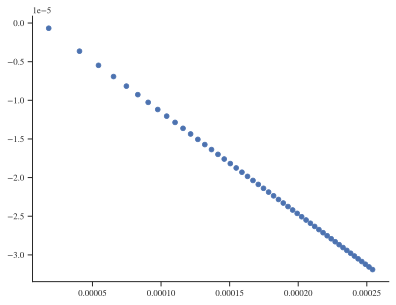

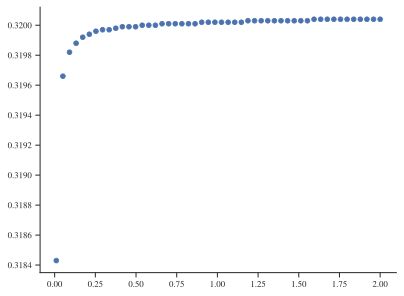

In [57]:
plt.scatter(particles0.x, particles0.y)
plt.show()

Jx, Jy = np.meshgrid(JJ[::10], JJ[::10])
plt.scatter(JJ, qx)
plt.show()

In [58]:
fp = collider.lhcb1.get_footprint(nemitt_x = 2.3e-06, nemitt_y = 2.3e-06, n_turns = 2000)

Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


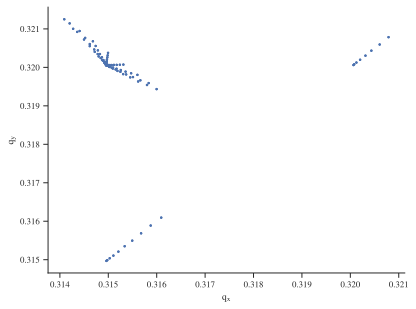

In [59]:
fp.plot(lw=0., color="b", marker = '.', markersize=3)

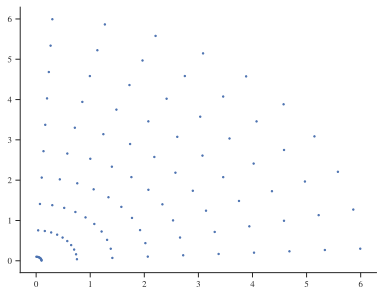

In [60]:
plt.plot(fp.x_norm_2d, fp.y_norm_2d, ".", color="b", markersize=3)

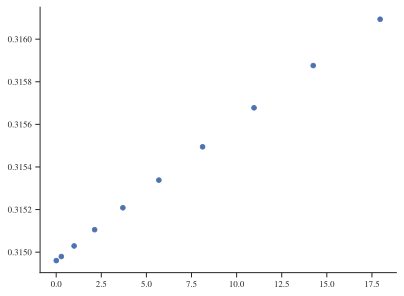

In [61]:
plt.scatter(fp.x_norm_2d[0]**2/2, fp.qx[0])

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


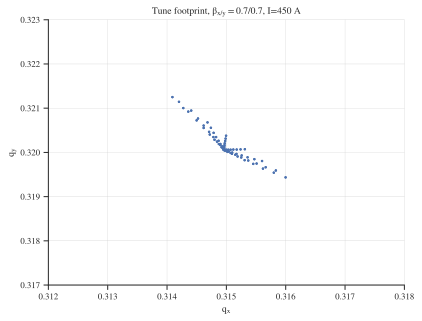

In [62]:
optics= l_optics[0]
betax, betay = l_beta[0]
I = 450

collider = xt.Multiline.from_json(optics)
collider.build_trackers()
collider.vars['beambeam_scale'] = 0
fp = collider.lhcb1.get_footprint(nemitt_x = 2.3e-06, nemitt_y = 2.3e-06, n_turns = 2000)
fp.plot(lw=0., color="b", marker = '.', markersize=3)
plt.xlim(0.312, 0.318)
plt.ylim(0.317, 0.323)
plt.title("Tune footprint, " + r"$\beta_{x/y} =$" + f"{betay}/{betax}, " + f"I={I} A")
plt.grid()
plt.savefig(f"footprint_{betay}_{betax}.png", dpi=300)
plt.show()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


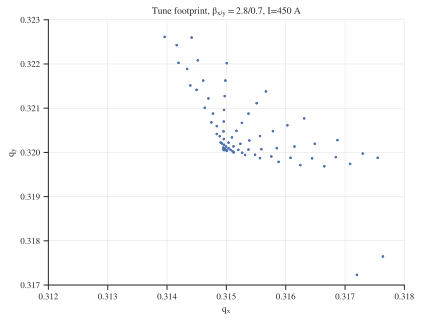

In [63]:
optics= l_optics[1]
betax, betay = l_beta[1]
I = 450

collider = xt.Multiline.from_json(optics)
collider.build_trackers()
collider.vars['beambeam_scale'] = 0
fp = collider.lhcb1.get_footprint(nemitt_x = 2.3e-06, nemitt_y = 2.3e-06, n_turns = 2000)
fp.plot(lw=0., color="b", marker = '.', markersize=3)
plt.xlim(0.312, 0.318)
plt.ylim(0.317, 0.323)
plt.title("Tune footprint, " + r"$\beta_{x/y} =$" + f"{betay}/{betax}, " + f"I={I} A")
plt.grid()
plt.savefig(f"footprint_{betay}_{betax}.png", dpi=300)
plt.show()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


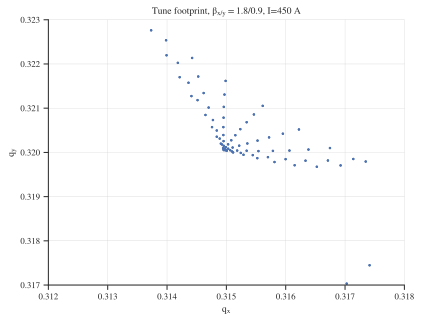

In [64]:
optics= l_optics[2]
betax, betay = l_beta[2]
I = 450

collider = xt.Multiline.from_json(optics)
collider.build_trackers()
collider.vars['beambeam_scale'] = 0
fp = collider.lhcb1.get_footprint(nemitt_x = 2.3e-06, nemitt_y = 2.3e-06, n_turns = 2000)

fp.plot(lw=0., color="b", marker = '.', markersize=3)
plt.xlim(0.312, 0.318)
plt.ylim(0.317, 0.323)
plt.grid()
plt.title("Tune footprint, " + r"$\beta_{x/y} =$" + f"{betay}/{betax}, " + f"I={I} A")
plt.savefig(f"footprint_{betay}_{betax}.png", dpi=300)

plt.show()